## Installation

In [1]:
import os
if not os.path.isfile('/content/model.pt'):
  !wget https://huggingface.co/Cene655/ImagenT5-3B/resolve/main/model.pt
  !pip install accelerate
  !pip install git+https://github.com/huggingface/transformers.git
  !pip install git+https://github.com/cene555/Imagen-pytorch.git
  !pip install git+https://github.com/openai/CLIP.git

In [2]:
from PIL import Image
from IPython.display import display
import torch as th
from imagen_pytorch.model_creation import create_model_and_diffusion as create_model_and_diffusion_dalle2
from imagen_pytorch.model_creation import model_and_diffusion_defaults as model_and_diffusion_defaults_dalle2
from transformers import AutoTokenizer
import cv2

import glob

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [3]:
from accelerate import init_empty_weights
from torch import LongTensor, FloatTensor, BoolTensor,nn
from typing import Iterator, List, Tuple, Dict

def get_keys_to_submodule(model: nn.Module) -> Dict[str, nn.Module]:
    keys_to_submodule = {}
    # iterate all submodules
    for submodule_name, submodule in model.named_modules():
        # iterate all paramters in each submobule
        for param_name, param in submodule.named_parameters():
            # param_name is organized as <name>.<subname>.<subsubname> ...
            # the more we go deep in the model, the less "subname"s we have
            splitted_param_name = param_name.split('.')
            # if we have only one subname, then it means that we reach a "leaf" submodule, 
            # we cannot go inside it anymore. This is the actual parameter
            is_leaf_param = len(splitted_param_name) == 1
            if is_leaf_param:
                # we recreate the correct key
                key = f"{submodule_name}.{param_name}"
                # we associate this key with this submodule
                keys_to_submodule[key] = submodule
                
    return keys_to_submodule

def load_state_dict_with_low_memory(model: nn.Module, state_dict):
    print('======hacky load======')
    # free up memory by placing the model in the `meta` device
    keys_to_submodule = get_keys_to_submodule(model)
    mste=model.state_dict()
    for key, submodule in keys_to_submodule.items():
        # get the valye from the state_dict
        if key in state_dict:
          val = state_dict[key]
        else:
          print(key)
          val = th.ones(mste[key].shape, dtype= torch.float32)
        # we need to substitute the parameter inside submodule, 
        # remember key is composed of <name>.<subname>.<subsubname>
        # the actual submodule's parameter is stored inside the 
        # last subname. If key is `in_proj.weight`, the correct field if `weight`
        param_name = key.split('.')[-1]
        #param_dtype = getattr(submodule, param_name).dtype
        #val = val.to(param_dtype)
        # create a new parameter
        new_val = th.nn.Parameter(val)
        setattr(submodule, param_name, new_val)

def model_fn(x_t, ts, **kwargs):
    guidance_scale = 5
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)
def show_images(batch: th.Tensor, savename='sav0'):
    """ Display a batch of images inline."""
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    th.save(scaled,savename+'.pt')
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))
def get_numpy_img(img):
    scaled = ((img + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([img.shape[2], -1, 3])
    return cv2.cvtColor(reshaped.numpy(), cv2.COLOR_BGR2RGB)
def _fix_path(path):
  d = th.load(path,map_location='cpu')
  checkpoint = {}
  for key in d.keys():
    checkpoint[key.replace('module.','')] = d[key]
  return checkpoint

## Setting Up

In [ ]:
options = model_and_diffusion_defaults_dalle2()
options['use_fp16'] = False
options['diffusion_steps'] = 200
options['num_res_blocks'] = 3
options['t5_name'] = 't5-3b'
options['cache_text_emb'] = True
with init_empty_weights():
  model, diffusion = create_model_and_diffusion_dalle2(**options)

load_state_dict_with_low_memory(model, _fix_path('/content/model.pt'))

model.requires_grad_(False).eval()

#if has_cuda:
#    model.convert_to_fp16()

model = model.cuda()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(options['t5_name'])

In [11]:
#@title What do you want to generate?

prompt = 'A blue cube on top of red cube on fire'#@param {type:"string"}

In [12]:
text_encoding = tokenizer(
    prompt,
    max_length=128,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

uncond_text_encoding = tokenizer(
    '',
    max_length=128,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

In [13]:
import numpy as np
batch_size = 4
cond_tokens = th.from_numpy(np.array([text_encoding['input_ids'][0].numpy() for i in range(batch_size)]))
uncond_tokens = th.from_numpy(np.array([uncond_text_encoding['input_ids'][0].numpy() for i in range(batch_size)]))
cond_attention_mask = th.from_numpy(np.array([text_encoding['attention_mask'][0].numpy() for i in range(batch_size)]))
uncond_attention_mask = th.from_numpy(np.array([uncond_text_encoding['attention_mask'][0].numpy() for i in range(batch_size)]))
model_kwargs = {}
model_kwargs["tokens"] = th.cat((cond_tokens,
                                 uncond_tokens)).to(device)
model_kwargs["mask"] = th.cat((cond_attention_mask,
                               uncond_attention_mask)).to(device)

## Generation

In [14]:
model.del_cache()
sample = diffusion.p_sample_loop(
    model_fn,
    (batch_size * 2, 3, 64, 64),
    clip_denoised=True,
    model_kwargs=model_kwargs,
    device='cuda',
    progress=True,
)[:batch_size]
model.del_cache()

  0%|          | 0/200 [00:00<?, ?it/s]

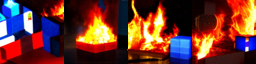

In [16]:
show_images(sample,'sav_cube')

In [ ]:
for i in sample:
    show_images(i.unsqueeze(0))

In [ ]:
new_img = get_numpy_img(sample)